##Luis David Pardo Pedraza

##Mask detection system for a health institution

Fictional case study with real data. Main focus is the usage of deep learning and computer vision techniques.

##Business problem

During the pandemic years, contact avoidance and mask wearing were some of the main traits that characterized global society. However, since the end of the pandemic, humanity has slowly returned to the old ways of living before Covid. The fear of catching the virus has been decreasing over time and individuals decided to put aside their masks and resume their contact with other people. Despite this, even if the pandemic is over, Covid still exists and the risk that people have of succumbing to other related or similar deseases convinced some health organizations to implement mask usage within their institutional rules.

I was hired from one of this institutions, called New Horizons Hospital, for helping the organization to monitor mask usage within their facilities. For this reason, I decided to build an automated mask detection system that can continuously monitor areas for mask compliance, ensuring that staff, patients, and visitors adhere to mask wearing policy. With this, the health institution can improve its infection control measures, promoting a safer environment for everyone.

By using a machine learning approach, I can build a model that can accurately detect if people in selected areas of the hospital are using or not a mask. The main idea for this pipeline is to deliver the model with the best possible performance for achieving this detection goal. For doing so, I am conducting different deep learning experiments (Convolutional Neural Network (CNN)) to prove that building a better model would be a challenge since the provided model is going to performe worse if it is modified.

###Importing libraries

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam

import os
import numpy as np
import random as python_random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

In [2]:
seed_value = 45
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
python_random.seed(seed_value)

##Data acquisition

For doing so, I'll be using to different datasets. These datasets contain, each one, photos of people with and without masks. The first dataset is going to be used for training and validating the model. The second dataset is used at the end to test performance and see if the model is up to deployment for general use.

The first dataset is called "Real-time Face Mask Detection using openCV" and can be found in the following link:
https://www.kaggle.com/datasets/electricalengineers/real-time-face-mask-detection-using-opencv?select=Face+Mask+Detection+using+openCV.ipynb

The second dataset is called "FaceMask Dataset" and can be found in the following link:
https://www.kaggle.com/datasets/sumansid/facemask-dataset

Both datasets are downloaded and stored in my pc. Both have one folder with images of people wearing masks and another folder of people without masks.

##Data Exploration

###Displaying sample images

For exploring the first image dataset, I display pictures of the two folders found in this dataset, which in this case are the two classes. First class is named "with mask" and second class is called "without mask". This classes are stored in a variable "classes"

For this display, a function "display_photos" is defined. Basically this function is set to show some images from a selected path or directory. In this case, the amount of images to display is 5 for each of the classes (a loop is made for iterating over each class). The selected path is where I stored the dataset and it is: "D:/PruebaTensor/dataset". That said path, is also saved in a variable "base_dir". 

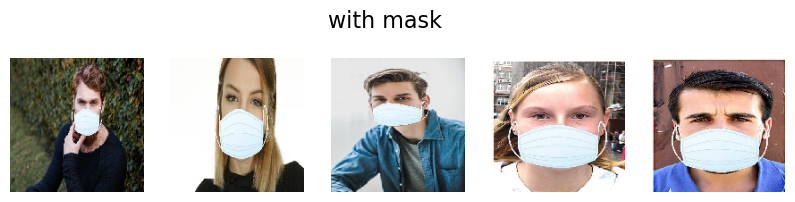

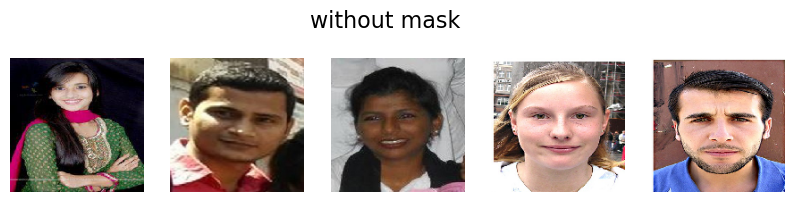

In [3]:
classes = ["with mask", "without mask"]

def display_photos(image_directory, title, num_images=5):
    plt.figure(figsize=(10, 8))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        img_path = os.path.join(image_directory, os.listdir(image_directory)[i])
        img = image.load_img(img_path, target_size=(150, 150))
        plt.imshow(img)
        plt.axis('off')
    plt.subplots_adjust(top=0.8)
    plt.suptitle(title, fontsize=16, y=0.6)
    plt.show()
base_dir = "D:/PruebaTensor/dataset"
for label in classes:
    display_photos(os.path.join(base_dir, label), label)

Above, we can see examples of both categories. As expected the class 1 shows people using a mask and class 2 people without mask.

###Classes and distribution

Now lets dive into the distribution of this dataset. To do so, a loop is used for counting the amount of elements in each class. The results are stored in a "class_counts" variable which is then printed.

In [4]:
class_counts = {}

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    count = len([name for name in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, name))])
    class_counts[class_name] = count

print("Class distribution:", class_counts)

Class distribution: {'with mask': 690, 'without mask': 686}


According to the results there are 690 photos of people wearing mask and 686 photos of people who don't do it. The distribution of the dataset can be better observed in the following bar chart.

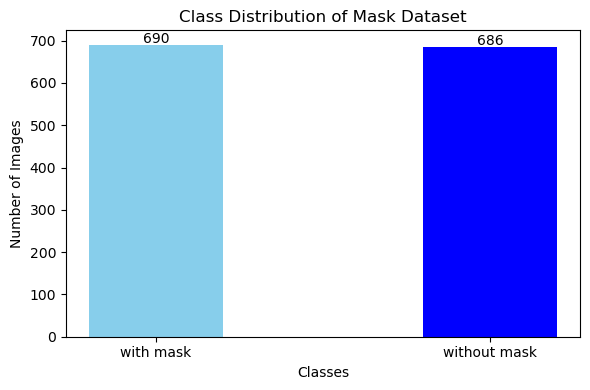

In [5]:
class_labels = list(class_counts.keys())
counts = list(class_counts.values())
plt.figure(figsize=(6, 4))
plt.bar(class_labels, counts, color=["skyblue", "blue"], width=0.4)
plt.title("Class Distribution of Mask Dataset")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(rotation=0)

for i in range(len(class_labels)):
    plt.text(i, counts[i] + 5, str(counts[i]), ha = "center", color = "black")

plt.tight_layout()
plt.show()

The previous graph, shows that this dataset does not present imbalance between the two clasess, since the amount of entries in each one is almost the same.

###Size of the dataset

In [6]:
total_size = sum(class_counts.values())
print("Size of the dataset:", total_size)

Size of the dataset: 1376


The total size of the dataset is obtained by summing the amount of images in both categories. So for this case the size is 1376 entries.

###Test set

####Size and distribution

As mentioned before, the second dataset is used for testing. This dataset originally had 208 images in the "with mask" class and 131 in the "without mask" class. After finding out this, I removed manually the last 77 images from the class 1 to balance the 2 classes. The current distribution can be seen in the following cell.

In [7]:
classes_test = ["with mask", "without mask"]
class_test_counts = {}

for class_name in classes_test:
    class_dir_test = os.path.join("D:\\PruebaTensor\\test", class_name)
    count_test = len([name for name in os.listdir(class_dir_test) if os.path.isfile(os.path.join(class_dir_test, name))])
    class_test_counts[class_name] = count_test

print("Class distribution Test set:", class_test_counts)

Class distribution Test set: {'with mask': 131, 'without mask': 131}


In [8]:
total_test_size = sum(class_test_counts.values())
print("Size of the dataset:", total_test_size)

Size of the dataset: 262


The size of the test set is 262 images with 131 entries for each class.

##Data loading, preprocessing and feature engineering

All of these steps will be happening while training the dataset. However, now I decide to create a couple of variables "datagenerator_for_training" and "datagenerator_for_validation" that stores all changes that are going to be made to the data when loading the dataset. These changes are the preprocessing and feature engineering steps for this case. I am explaining each of these steps in the following subsections.

-Data preprocessing

-Feature engineering

-Split data into training and validation sets

-Data loading

###Data preprocessing

Preprocessing is applied to training and validation. For this case, the images are normalized using the 'rescale' parameter. This step is essential to standardize the pixel values across all images.

Also I make that the images are resized with a new size of 150x150 pixels.

###Feature engineering

Regarding feature engineering, I decide to conduct data augmentation just for the training set. With this, realistic images are going to be generated from the ones of the original dataset. This is useful because it helps to have data diversity, prevent overfitting and improve overall robustness of the constructed model.

Here is a brief summary of the augmentation techniques that will be applied:

Rotating: Rotates an image by some degrees

Shifting: Moves an image vertically or horizontally

Shearing: distorts an image

Zooming: zooms in or out an image

Flipping: Makes the image look like it would be if projected by a mirror

###Split data into training and validation sets

The data splitting is also part of this variable and for this case 20% of the data is going to be used for validation and the rest 80% for training.

###Data loading

Data loading is going to happen while the traning step. Here I am setting the parameters that data will have while loading. These parameters are the following:

-Process the data with the characteristic stored in the "datagenerator_for_training" variable previously defined.

-Access to the path where dataset is stored and load it

-The amount of images that the model processes in each iteration

-Stating that this is a binary class task (with mask and without mask)

-Decide to use the traning or the validation set

-Seeding for ensuring reproducibility

In [9]:
datagenerator_for_training = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    validation_split=0.2
)

datagenerator_for_validation = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 
)

train_generator = datagenerator_for_training.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary",
    subset="training",
    seed=45
)

validation_generator = datagenerator_for_validation.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary",
    subset="validation",
    seed=45
)

Found 1101 images belonging to 2 classes.
Found 275 images belonging to 2 classes.


As can be observed, when the dataset is split, 1101 images will be used for training and 275 images will be used for validation.

##Measure selection

Since my dataset is balanced and I consider that both categories are equally important for the task, I am choosing accuracy as my main metric for evaluating performance. This metric provides a proportion of the correctly classified images. Additionally, I'll tak into account validation loss as a secondary measure. This helps to see "how well the model generalizes to the validation set. It represents the error on unseen data. An increasing validation loss indicates that the model’s performance on the validation set is worsening, suggesting that it is becoming less effective at generalizing to new data" (Geeksforgeeks, 2024). The combination fot the two selected metrics helps me to ensure a great performance from the model while still considering future deployment on new data.

##Best model

###Architecture

In [10]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"]) 

Here the architecture of the best model is set. Here is an explanation of this architecture.

-The model expexts as input 150x150 pixels images with 3 color values (for RGB). 

-3 Convulutional layers are used with a size of 3x3. Filters increase on each convulutional layer (32, 64 and 128).

-3 Pooling layers are used after each convulutional layer "for reducing the spatial dimensions" (Dremio, 2024).

-1 Flattening layer that basically converts the image data into a one dimension vector.

-1 Dense layer with 256 neurons.

-1 Dropout layer that helps to prevent overfitting by excluding "various training runs using a probability, as if they were not part of the network architecture at all". (Data Base Camp, 2023)

-1 final Dense layer with just 1 unit to make the output deliver a single result whih then will be processed for selecting the class. This one is activated by the Sigmoid function.

-Relu is used as the main activation function for each convulutional layer and for the dense layer.

-Adam is choosen as the optimizer algorithm and since this is a binary classification task the Binary Crossentropy formula is assigned to the loss function. Accuracy is set as the evaluation metric.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In the table above, it can be seen the architecture of the best model I could build for this task.

###Training the model

For training the model, I am using a regularization technique known as Early Stopping. With this, I "stop training the model when the performance on the validation set is getting worse- increasing loss decreasing accuracy, or poorer scores of the scoring metric" (Geeksforgeeks, 2023). So in this case, if the validation loss does not improve for 5 consecutive epochs, training is stopped. The maximum number of epochs is set at 15.

Here the train generator provides the data applying all the steps explained in the "Data loading, preprocessing and feature engineering" section. The model is trained and evaluates all validation samples in one epoch.

The "restore_best_weights" parameter is set to True to have as an output the model that performs best on the validation set.

In [12]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

In [13]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    callbacks=[early_stopping],
    verbose=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']


###Results on validation set

In [14]:
best_val_accuracy = np.max(history.history["val_accuracy"]) * 100
best_val_loss = np.min(history.history["val_loss"])

print(f"Best Validation Accuracy: {best_val_accuracy}%")
print(f"Best Validation Loss: {best_val_loss}")

Best Validation Accuracy: 99.61538314819336%
Best Validation Loss: 0.015630596926292546


According to the output the information above, the best model had an excellent performance on the validation set with more than 99% of accuracy in its best Epoch. Additionally, the validation loss is very close to 0 which means that this model could perform well with other data. These are good news because it seems that the model is ready for deployment.

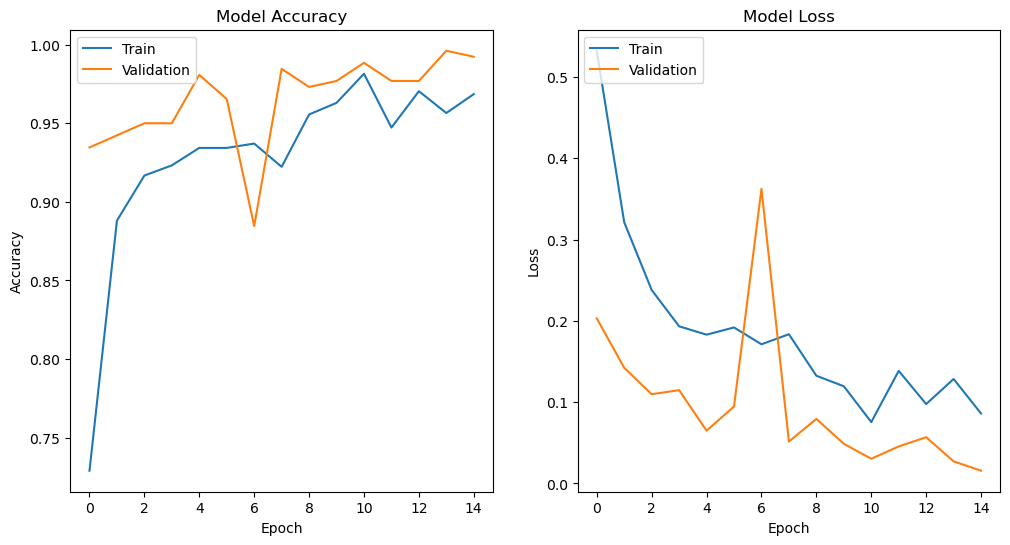

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

The first graph, shows that the model overall presented a great performance across the Epochs. Starting from the Epoch 4 it sustained an accuracy over 95% (only exception being Epoch 6) reaching its peak in the Epoch 13. 

On the other hand, according to the second graph validation loss was below 0.1 since the Epoch 4 and stayed like this going foward (only exception being Epoch 6).

####Storing results for further comparison with experiments

In [16]:
experiment_id = "Best Model"
configuration = "3 Conv + Dense 256 + Dropout 0.4"
results_df = pd.DataFrame(columns=["Experiment ID", "Configuration", "Validation Accuracy", "Validation Loss"])
results_df = results_df.append({
    "Experiment ID": experiment_id,
    "Configuration": configuration,
    "Validation Accuracy": best_val_accuracy,
    "Validation Loss": best_val_loss
}, ignore_index=True)

In [17]:
results_df

,Experiment ID,Configuration,Validation Accuracy,Validation Loss
0,Best Model,3 Conv + Dense 256 + Dropout 0.4,99.615383,0.015631


###Experiments

For proving that my best model is indeed the best I could build, I tried different approaches of deep learning models to try to beat my best model in performance taking into account the two selected metrics.

Best model architecture comprises 3 convulutional layers, 1 dense layer with 256 dense neurons and a dropout of 0.4. It is activated with the Relu and Sigmoid functions.

Experiments' changes regarding the best model:

Experiment 1: lower drop rate (0.3)

Experiment 2: 2 convolutional layers (1 less than best)

Experiment 3: uses the double amount of dense neurons (512)

Experiment 4: higher drop rate (0.5)

Experiment 5: 4 convulutional layers (1 more than best)

Experiment 6: sets the filters to 64 for the 3 convulutional layers (original has 32, then 64 and then 128).

Experiment 7: adds a second dense layer with 128 neurons

Experiment 8: applies batch normalization technique to the convulutional layers

Experiment 9: the learning rate is increased to 0.01 (orginal has default learning rate which is 0.001)

Experiment 10: the activation function is changed to ELU instead of Relu

Experiment 11: No dropout (Drop rate is 0)

All the configurations are set in the following dctionary "combined_configs"

In [18]:
combined_configs = [
    {'id': "Experiment 1", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0.3},
    {"id": "Experiment 2", "conv_layers": 2, "dense_neurons": 256, "dropout_rate": 0.4},
    {"id": "Experiment 3", "conv_layers": 3, "dense_neurons": 512, "dropout_rate": 0.4},
    {"id": "Experiment 4", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0.5},
    {"id": "Experiment 5", "conv_layers": 4, "dense_neurons": 256, "dropout_rate": 0.4},
    {"id": "Experiment 6", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0.4, "filters": 64},
    {"id": "Experiment 7", "conv_layers": 3, "dense_neurons": [256, 128], "dropout_rate": 0.4},
    {"id": "Experiment 8", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0.4, "use_batch_norm": True},
    {"id": "Experiment 9", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0.4, "learning_rate": 0.01},
    {"id": "Experiment 10", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0.4, "activation": "elu"},
    {"id": "Experiment 11", "conv_layers": 3, "dense_neurons": 256, "dropout_rate": 0}
]

Now a function is defined and the parameters that are going to be applied to each model are set. A loop is created for iterating among each configuration stored in the previously defined dictionary. The function basically vary the hyperparameters of the model across the multiple configurations.

In [19]:
def create_model(conv_layers, dense_neurons, dropout_rate, filters=32, use_batch_norm=False, learning_rate=0.001, activation='relu'):
    model = Sequential()
    for i in range(conv_layers):
        if i == 0:
            model.add(Conv2D(filters, (3, 3), activation=activation, input_shape=(150, 150, 3)))
        else:
            model.add(Conv2D(filters * 2**i, (3, 3), activation=activation))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(2, 2))
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    if isinstance(dense_neurons, list):
        for neurons in dense_neurons:
            model.add(Dense(neurons, activation=activation))
    else:
        model.add(Dense(dense_neurons, activation=activation))

    model.add(Dense(1, activation="sigmoid"))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

The previous defined function is used to train the models. The results are calculated using the accuracy and validation loss metrics. Finally the results are stored in a dataframe "other_results_df". The characteristics of each configuration are defined in "config_description" variable.

In [20]:
results_list = []

for config in combined_configs:
    model_config = {key: value for key, value in config.items() if key not in ['id']}
    
    model = create_model(**model_config)
    
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=15,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping],
        verbose=0
    )
    
    best_val_accuracy = np.max(history.history["val_accuracy"]) * 100
    best_val_loss = np.min(history.history["val_loss"])

    config_description = f"{config['conv_layers']} Conv + Dense {config['dense_neurons']} + Dropout {config['dropout_rate']}" + \
                         (f", Filters {config.get('filters', 32)}" if 'filters' in config else "") + \
                         (", Batch Norm" if config.get('use_batch_norm', False) else "") + \
                         (f", LR {config.get('learning_rate', 0.001)}" if 'learning_rate' in config else "") + \
                         (f", Activation {config.get('activation', 'relu')}" if 'activation' in config else "")

    results_list.append({
        "Experiment ID": config["id"],
        "Configuration": config_description,
        "Validation Accuracy": best_val_accuracy,
        "Validation Loss": best_val_loss
    })

other_results_df = pd.DataFrame(results_list)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']
  ...
    to  
  ['...']


In [21]:
experiments_results_df = other_results_df.copy()

In [22]:
experiments_results_df = pd.concat([results_df, experiments_results_df], ignore_index=True)

In [23]:
experiments_results_df

,Experiment ID,Configuration,Validation Accuracy,Validation Loss
0,Best Model,3 Conv + Dense 256 + Dropout 0.4,99.615383,0.015631
1,Experiment 1,3 Conv + Dense 256 + Dropout 0.3,98.461539,0.033534
2,Experiment 2,2 Conv + Dense 256 + Dropout 0.4,97.307694,0.094283
3,Experiment 3,3 Conv + Dense 512 + Dropout 0.4,98.461539,0.040084
4,Experiment 4,3 Conv + Dense 256 + Dropout 0.5,99.615383,0.017977
5,Experiment 5,4 Conv + Dense 256 + Dropout 0.4,99.615383,0.023693
6,Experiment 6,"3 Conv + Dense 256 + Dropout 0.4, Filters 64",99.230766,0.030808
7,Experiment 7,"3 Conv + Dense [256, 128] + Dropout 0.4",99.230766,0.017335
8,Experiment 8,"3 Conv + Dense 256 + Dropout 0.4, Batch Norm",98.076922,0.087214
9,Experiment 9,"3 Conv + Dense 256 + Dropout 0.4, LR 0.01",50.769234,0.693032


As can be seen in the table above, the best model got one of the highest performance. Additionally,  the validation loss of the best model is the lowest among all experiments. This means that modifying harms its performance, at least with the experiments tested in this pipeline.

These experiments shows that removing convulutional layers, adding convulutional layers, increasing drop rate, decreasing drop rate, setting filters to 64, adding an extra dense layer, using batch normalization, increasing the learning rate, changing the activation function or removing dropout can make worse the performance of the model.

##Using the best model on testing set

Finally, the best model is ready to be used for the testing set. However, before that I am conducting the same preprocessing steps on the test data. Data augmentation is not used since the idea is to have the most realistic evaluation of the model as possible.

###Testing set preprocessing and loading

Images are normalized and resized.

In [24]:
datagenerator_for_testing = ImageDataGenerator(
    rescale=1./255
)

test_dir = "D:/PruebaTensor/test"
test_generator = datagenerator_for_testing.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode="binary",
    shuffle=False
)

Found 260 images belonging to 2 classes.


###Evaluating the best model on testing set

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

  ...
    to  
  ['...']
13/13 [==============================] - 4s 319ms/step - loss: 0.8906 - accuracy: 0.7038
Test Accuracy: 70.38%
Test Loss: 0.8906


After evaluating the model, accuracy is about 70% and test loss is 0.9. This means that the performance is good but the model has room for improvement.

###Confusion matrix

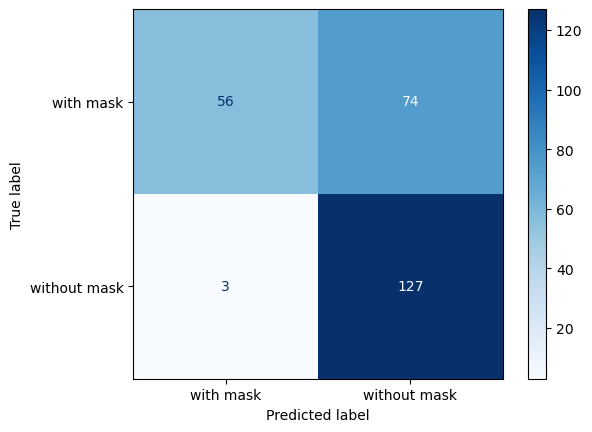

In [29]:
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
predicted_classes = np.round(predictions).astype(int).flatten()
true_classes = test_generator.classes
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
disp.plot(cmap="Blues")

plt.show()

As can be seen in the confusion matrix, the model presented a harder time classifying the images of the with mask class category. It managed to classify correctly 56 out of 130 images of the with mask category. Regarding without mask category the model performed way better by accurately predicting 127 images out of 130. Despite this, it is evident that there is room for improvement since the model missed 74 images of the with mask category and only 3 photos of the without mask category.

##Classification report

In [27]:
report = classification_report(true_classes, predicted_classes, target_names=test_generator.class_indices.keys())
print(report)

              precision    recall  f1-score   support

   with mask       0.95      0.43      0.59       130
without mask       0.63      0.98      0.77       130

    accuracy                           0.70       260
   macro avg       0.79      0.70      0.68       260
weighted avg       0.79      0.70      0.68       260



The table above also reflects what the confusion matrix showed. The model is a little biased towards the without mask category. It got 77% on F1 score for this category. However, the F1 score for the with mask category is just 59%. Despite this, having an accuracy of 70% confirms that the model performed quite well in its primary task of detecting whether people are wearing masks or not.

##Final discussion

To conclude there are a few things that must be said about this pipeline:

As the main strength, the mask detection system built in this pipeline could be very useful for the New Horizons Hospital. Its current performance (70% of accuracy) allows the system to deal good enough with its main task of detecting people that are not wearing a mask in the Hospital's facilities. With this, it can be affirmed that the pipeline provides a solution to the business problem stated at the beginning of the study. 

Even if the model has quite good performance, the system still has room for improvement. Ideally, some measures would be taken to increase accuracy even more and reach a point where the system can easily detect people wearing masks. Indeed, one limitation to highlight is that the system presents a harder time detecting people wearing a mask than detecting people that don't use a mask. 

It should be noted that there is a gap of almost 30% between the performance of the model on validation set and test set. This gap could be somehow related to the fact that the model was tested with a completely different dataset which means that maybe further preprocessing steps were needed on the test set for giving the model more similar data to the used for training. This could have helped the model to have an easier time classifying the images. The metioned gap could also imply that the model may be suffering from overfitting.

Another recommendation is to collect more photos and make the training dataset bigger. This can increase the model robustness and learn more complex patterns that can foster overall performance.

##References

Data Base Camp (2023) What is the Dropout Layer? Available at: https://databasecamp.de/en/ml/dropout-layer-en. (Accessed: July 1 2024)

Dremio (2024) What is Pooling Layers? Available at: https://www.dremio.com/wiki/pooling-layers/#:~:text=Pooling%20Layers%2C%20also%20known%20as,retaining%20the%20most%20important%20information. (Accessed: July 1 2024)

Geeksforgeeks (2024) Why an Increasing Validation Loss and Validation Accuracy Signifies Overfitting? Available at: https://www.geeksforgeeks.org/why-an-increasing-validation-loss-and-validation-accuracy-signifies-overfitting/. (Accessed: July 1 2024)

Geeksforgeeks (2023) Regularization by Early Stopping. Available at https://www.geeksforgeeks.org/regularization-by-early-stopping/. (Accessed: July 1 2024)

Kokne A. (2023) Real-time Face Mask Detection using openCV. Available at https://www.kaggle.com/datasets/electricalengineers/real-time-face-mask-detection-using-opencv?select=Face+Mask+Detection+using+openCV.ipynb. (Accessed: June 25 2024)

Sumansid (2020) FaceMask Dataset. Available at https://www.kaggle.com/datasets/sumansid/facemask-dataset. (Accessed: June 25 2024)